### DRUG REVIEW SENTIMENT ANALYISIS - USING NLP(Natural Language processing)



#### Notebook Contributors

-  Swathi Subramanyam Pabbathi : Data cleaning/preparation, data preprocessing, model training and evaluation(implemented BERT - pretrained transformer model fine tuning), conclusion and recommendations.

-  Michael Skirvin : code review and fine tuning.

####  Project Setup

Create or Update environemnt

a. Add dependencies in environment.yaml

b. Run setup-env.ipynb that will check and create/update environment with required libraries

c. Now you can use the created environment to set as interpretor to your project

#### Dataset Overview

The Drug Review Dataset from the UCI Machine Learning Repository is utilized for this analysis. It contains 161,297 entries with the following 7 features:

•	drugName: The name of the drug.

•	condition: The medical condition for which the drug was prescribed.

•	review: The text review provided by the patient.


•	rating: A 10-star rating reflecting overall patient satisfaction.

•	date: The date the review was posted.

•	usefulCount: The number of users who found the review useful.


Target Variable: The sentiment of the review, which needs to be derived from the rating. A review rating above a certain threshold (e.g., 7/10) will be classified as positive, while a rating below this threshold will be classified as negative.However the rating provides a numerical representation of a user’s satisfaction (on a scale of 1 to 10) while the review text contains much richer, nuanced information that the rating alone cannot capture.

The objective of this project is to perform sentiment analysis on patient reviews for various drugs. The goal is to predict the sentiment (positive or negative) of reviews based on textual data and related features such as drug name, condition treated, and patient ratings. The sentiment prediction will help pharmaceutical companies and healthcare professionals gain insights into patient satisfaction, identify potential issues with drugs, and ultimately improve patient outcomes.

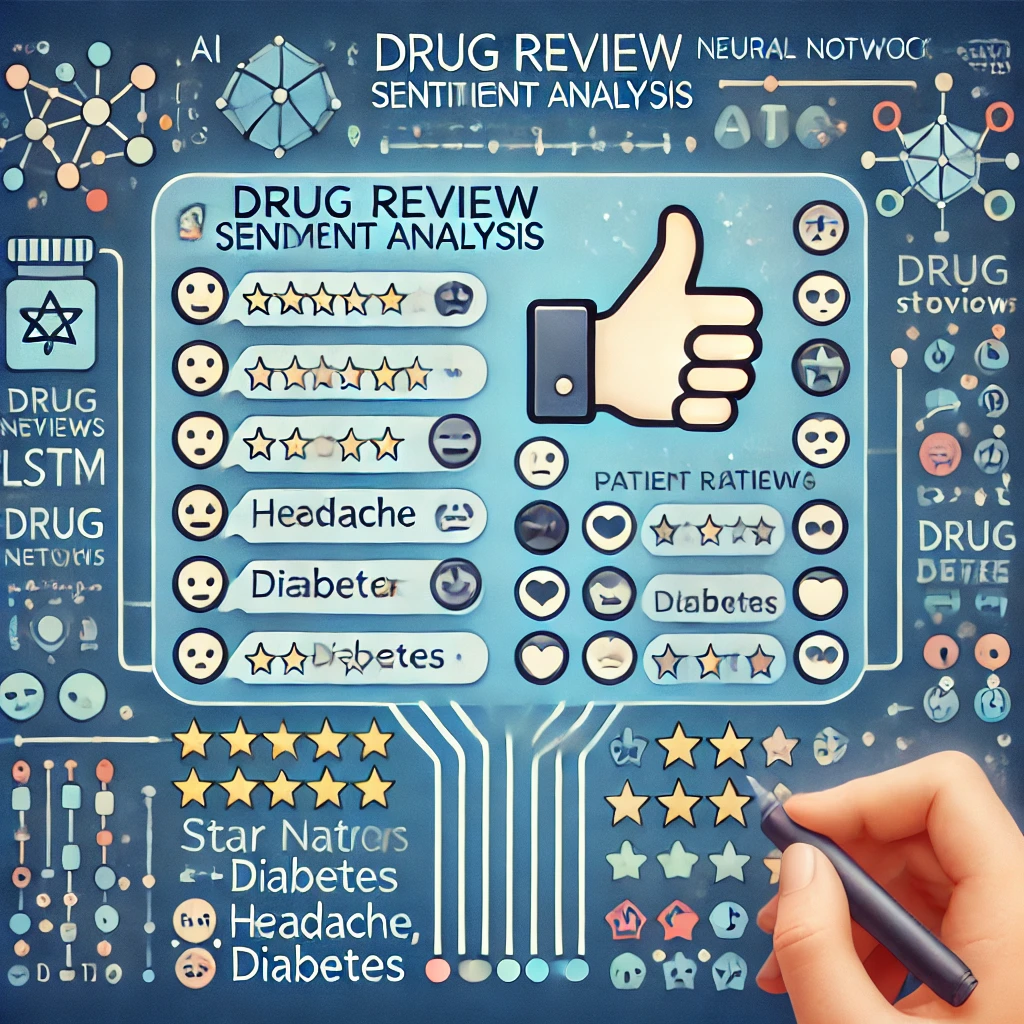

**Steps**
1. Data Collection, Exploration and Preprocessing
2. EDA
3. Pre-Modelling Data Preparation
4. Model Building
5. Model Evaluation
6. Summary

### DATA COLLECTION

In [1]:
# ## 1. Data Collection

import torch  # Import the PyTorch library
from datetime import datetime  # Import the datetime module for time tracking
import gdown
import zipfile
import json
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

In [2]:
import pandas as pd

# Replace 'path/to/your/file.tsv' with the actual path to your .tsv file
file_path1 = './data/drugsComTrain_raw.tsv'
file_path2 = './data/drugsComTest_raw.tsv'
# Load the .tsv file into a DataFrame
train = pd.read_csv(file_path1, sep='\t', index_col=0)
test  = pd.read_csv(file_path2, sep='\t', index_col=0)

# Reset index and rename it to 'UniqueId'
train.reset_index(inplace=True)
test.reset_index(inplace=True)

train.rename(columns={'index': 'UniqueId'}, inplace=True)
test.rename(columns={'index': 'UniqueId'}, inplace=True)

# Combine the train and test datasets into a single DataFrame
combined = pd.concat([train, test], ignore_index=True)

# Display the shape of the combined dataset and the first few rows
print(f"Combined dataset shape: {combined.shape}")
combined.head()


Combined dataset shape: (215063, 7)


,UniqueId,drugName,condition,review,rating,date,usefulCount
0,206461,Valsartan,Left Ventricular Dysfunction,"""It has no side effect, I take it in combinati...",9.0,"May 20, 2012",27
1,95260,Guanfacine,ADHD,"""My son is halfway through his fourth week of ...",8.0,"April 27, 2010",192
2,92703,Lybrel,Birth Control,"""I used to take another oral contraceptive, wh...",5.0,"December 14, 2009",17
3,138000,Ortho Evra,Birth Control,"""This is my first time using any form of birth...",8.0,"November 3, 2015",10
4,35696,Buprenorphine / naloxone,Opiate Dependence,"""Suboxone has completely turned my life around...",9.0,"November 27, 2016",37


In [3]:
# Check the shape of the train and test datasets
print("Shape of Training Data:", train.shape)
print("Shape of Testing Data:", test.shape)


Shape of Training Data: (161297, 7)
Shape of Testing Data: (53766, 7)


In [4]:
print("unique values count of train : " ,len(set(combined['UniqueId'].values)))
print("length of train : " ,combined.shape[0])

unique values count of train :  215063
length of train :  215063


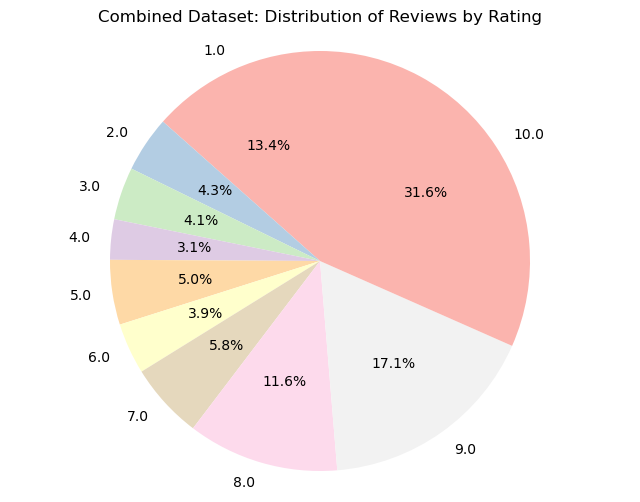

In [5]:
import matplotlib.pyplot as plt

# Count the number of reviews for each rating in the combined dataset
rating_counts = combined['rating'].value_counts().sort_index()

# Plotting a pie chart for the distribution of ratings in the combined dataset
plt.figure(figsize=(8, 6))
plt.pie(rating_counts, labels=rating_counts.index, autopct='%1.1f%%', startangle=90, colors=plt.cm.Pastel1.colors)
plt.title('Combined Dataset: Distribution of Reviews by Rating')
plt.axis('equal')  # Equal aspect ratio ensures that the pie is drawn as a circle
plt.show()


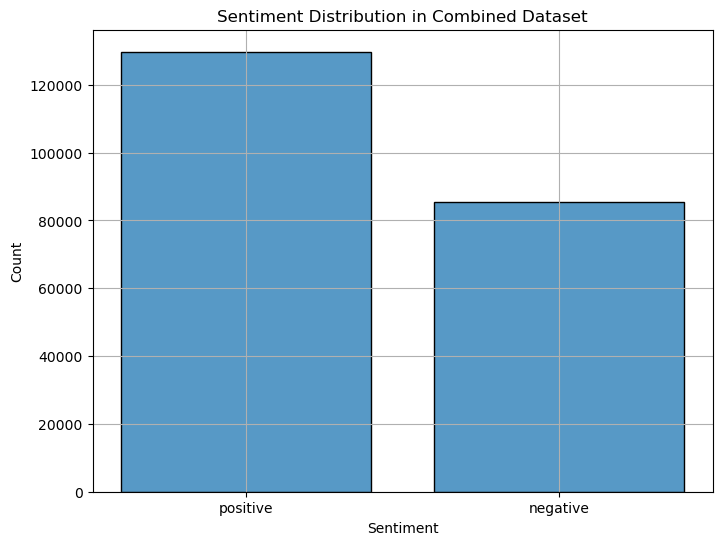

In [6]:

import matplotlib.pyplot as plt
import seaborn as sns

# Create the 'sentiment' feature in the combined dataset
combined['sentiment'] = combined['rating'].apply(lambda x: 'positive' if x >= 8 else 'negative')

# Plotting the sentiment distribution
plt.figure(figsize=(8, 6))
sns.histplot(combined['sentiment'], bins=2, shrink=0.8, edgecolor='black')
plt.title('Sentiment Distribution in Combined Dataset')
plt.xlabel('Sentiment')
plt.ylabel('Count')
plt.grid(True)
plt.show()

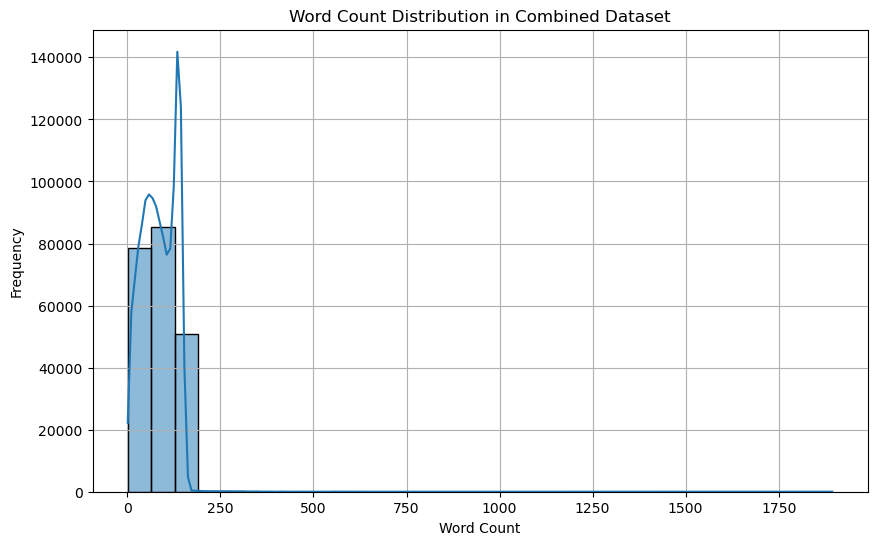

In [7]:
import matplotlib.pyplot as plt
import seaborn as sns

# Calculate word count directly on the 'review' column of the combined dataset
word_counts = combined['review'].dropna().apply(lambda x: len(str(x).split()))

# Plot the distribution of word counts
plt.figure(figsize=(10, 6))
sns.histplot(word_counts, bins=30, kde=True, edgecolor='black')
plt.title('Word Count Distribution in Combined Dataset')
plt.xlabel('Word Count')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()

In [8]:
# Filter reviews with word count greater than 400 in the combined dataset
combined_filtered = combined[combined['review'].apply(lambda x: len(str(x).split()) > 400)]

# Display the size of the filtered dataset
print(f"Number of reviews with word count > 400: {combined_filtered.shape[0]}")

# display the first few rows of the filtered dataset
combined_filtered.head()

Number of reviews with word count > 400: 65


,UniqueId,drugName,condition,review,rating,date,usefulCount,sentiment
55,102449,Aripiprazole,Schizophrenia,"""Abilify 20 mg.\r\nI am a patient diagnosed wi...",10.0,"September 25, 2016",26,positive
6982,152740,Doxycycline,Lyme Disease,"""June 20 2017 I walked in back of my fence are...",9.0,"November 12, 2017",0,positive
7466,184694,Canagliflozin,"Diabetes, Type 2","""At first I liked it. My Endocrinologist was w...",1.0,"April 17, 2017",26,negative
14108,60779,MoviPrep,Bowel Preparation,"""My colonoscopy was booked in for late afterno...",10.0,"March 17, 2016",42,positive
18277,64331,Sertraline,Social Anxiety Disorde,"""Maybe my experience can help someone else... ...",10.0,"October 20, 2016",96,positive


Seems there are outliers which has more than 400 words in the dataset. They can be removed in further processing

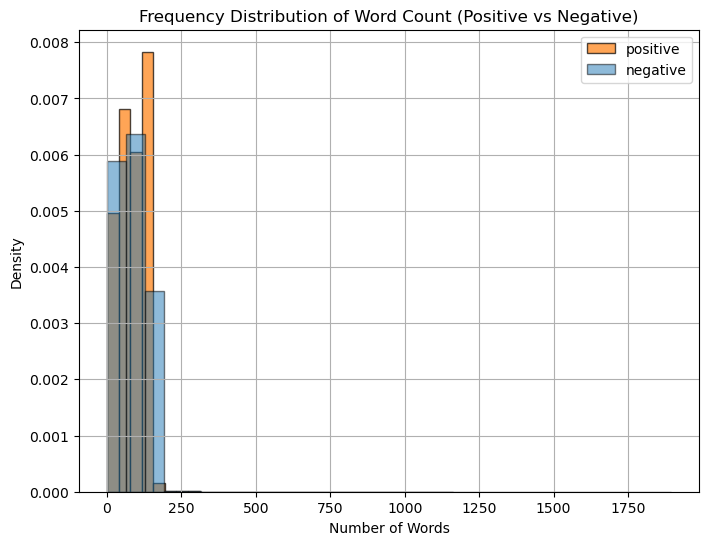

In [9]:
plt.figure(figsize=(8, 6))

# Calculate the number of words in each review
combined['word_count'] = combined['review'].apply(lambda x: len(str(x).split()))

# Filter reviews into positive and negative categories
pos_reviews = combined[combined['sentiment'] == 'positive']['word_count']
neg_reviews = combined[combined['sentiment'] == 'negative']['word_count']

plt.hist(pos_reviews, bins=30, color='#ff7f0e', edgecolor='black', alpha=0.7, label='positive', density=True)
plt.hist(neg_reviews, bins=30, color='#1f77b4', edgecolor='black', alpha=0.5, label='negative', density=True)

plt.title('Frequency Distribution of Word Count (Positive vs Negative)')
plt.xlabel('Number of Words')
plt.ylabel('Density')
plt.legend()
plt.grid(True)
plt.show()

From the above plot it is clearly observed that majority of postive reviews has the number of words nearly in between 50 and 160,
where as majority of negative reviews has number of words between 0 and 190 

###  Observations

1. Found to be there are more positive reviews and less negative reviews.Which is an imbalanced dataset.

2. By comparing the word count distribution between positive and negative reviews. It is observed that both positive and negative reviews tend to be longer and comparatively negative reviews are slightly longer which gives in-depth analysis r plot explanations making more sense.

### DATA PREPROCESSING

In [10]:
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)

In [11]:
import pandas as pd
from sklearn.utils import resample

# Separate majority and minority classes
positive = combined[combined['sentiment'] == 'positive']
negative = combined[combined['sentiment'] == 'negative']

# Perform random oversampling for the minority class
negative_oversampled = resample(negative,
                                replace=True,     # Sample with replacement
                                n_samples=len(positive),  # Match number in majority class
                                random_state=42)  # For reproducibility

# Combine the oversampled minority class with the majority class
comb_balanced = pd.concat([positive, negative_oversampled])

# Shuffle the dataset
comb_balanced = comb_balanced.sample(frac=1, random_state=42).reset_index(drop=True)

print(comb_balanced['sentiment'].value_counts())

sentiment
negative    129759
positive    129759
Name: count, dtype: int64


In [12]:
print(comb_balanced['review'][1])

"I am using Mobic for a rotator cuff strain and myofacial pain in my shoulder stabilizers.  It works great for that.  I made the mistake of using it without food and it has made me very sick.  Dizziness and nausea.  I also found I have to take it at night because it makes me very drowsy."


first, noticeable parts are the html strings like \ r \ n, and the parts that express emotions in parentheses such as (very unusual for him) and (a good thing) and words in capital letters like MUCH

In [13]:
print(comb_balanced['review'][9])

"I hope it can help you to choose to switch or not to this med..
I was on Atripla for 5 years (everything great but some common side effects like the alcohol feeling after 1 hour taking it). My doc told me there is a new one lighter for long time use and without neurological side effects, Genvoya.
First day (maybe because of the switch): nausea all night and vomit
First week: a really strong headache all day long and dizzy spells. And when someone use sarcasm for example I couldn&#039;t get it directly like my brain was so looow. Also to focus on a talk it was really hard.
I wasn&#039;t not me anymore.
So I told my doc and he said it&#039;s ok you tried enough you can restart Atripla from tonight and I REALLY prefere my 1 h drunk feeling than this all day!"


####  Create a word cloud
This helps in visualizing important words in the dataset, the words that are being mostly used.

**Hint**- You would want to ideally remove the stopwords before creating a word cloud since the stopwords generally would be the most frequent words but those don't give any insights, right? Also, you can create word clouds for both the classes!

In [14]:
## remove stopwords- use nltk or spacy for that
## create wordcloud for both the classes & visualize
import nltk

# Re-download the required NLTK data
nltk.download('punkt')  # For tokenization
nltk.download('stopwords')  # For stopwords

[nltk_data] Downloading package punkt to C:\Users\mikes/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\mikes/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [15]:
import os
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize

# Set the NLTK data path explicitly (if needed)
nltk_data_path = os.path.expanduser('~/nltk_data')
nltk.data.path.append(nltk_data_path)

# Download the required packages
nltk.download('punkt', download_dir=nltk_data_path)
nltk.download('stopwords', download_dir=nltk_data_path)

# Check if stopwords are correctly loaded
print(stopwords.words('english')[:10])  # Should print the first 10 stopwords

['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're"]


[nltk_data] Downloading package punkt to C:\Users\mikes/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\mikes/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [16]:
# Test the tokenization
print(word_tokenize("This is a test sentence."))  # Should print the tokenized words

['This', 'is', 'a', 'test', 'sentence', '.']


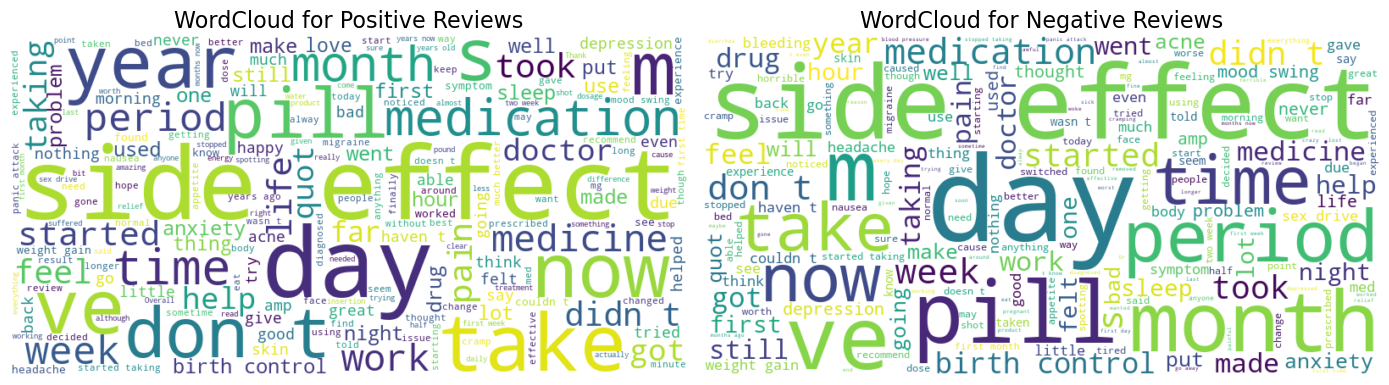

In [17]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt

# Create WordClouds for both sentiment classes: 'positive' and 'negative'

# For 'positive' sentiment
positive_reviews = " ".join(comb_balanced[comb_balanced['sentiment'] == 'positive']['review'].tolist())
wordcloud_positive = WordCloud(width=800, height=400, background_color='white').generate(positive_reviews)

# For 'negative' sentiment
negative_reviews = " ".join(comb_balanced[comb_balanced['sentiment'] == 'negative']['review'].tolist())
wordcloud_negative = WordCloud(width=800, height=400, background_color='white').generate(negative_reviews)

# Plotting the WordClouds
plt.figure(figsize=(14, 7))

# WordCloud for 'positive' sentiment
plt.subplot(1, 2, 1)
plt.imshow(wordcloud_positive, interpolation='bilinear')
plt.title('WordCloud for Positive Reviews', fontsize=16)
plt.axis('off')

# WordCloud for 'negative' sentiment
plt.subplot(1, 2, 2)
plt.imshow(wordcloud_negative, interpolation='bilinear')
plt.title('WordCloud for Negative Reviews', fontsize=16)
plt.axis('off')

# Display both word clouds
plt.tight_layout()
plt.show()

In [18]:


nltk.download('wordnet')

# Define stopwords
stop_words = set(stopwords.words('english'))

# Function to remove stopwords from a given text
def remove_stopwords(text):
    words = word_tokenize(text)  # Tokenize the review text
    words_filtered = [word for word in words if word.lower() not in stop_words]  # Filter out stopwords
    return " ".join(words_filtered)  # Rejoin the filtered words into a string

# Apply the function to remove stopwords from the 'review' column
comb_balanced['cleaned_review'] = comb_balanced['review'].apply(lambda x: remove_stopwords(str(x)))

# Display a few examples of the cleaned reviews
print(comb_balanced[['review', 'cleaned_review']].head())

[nltk_data] Downloading package wordnet to C:\Users\mikes/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


                                              review  \
0  "Well this was my first experience with any bi...   
1  "I am using Mobic for a rotator cuff strain an...   
2  "My dermatologist prescribed me epiduo because...   
3  "After 2 days of taking this I got blurred vis...   
4  "I love how all of you say that you can&#039;t...   

                                      cleaned_review  
0  `` Well first experience birth control fan . f...  
1  `` using Mobic rotator cuff strain myofacial p...  
2  `` dermatologist prescribed epiduo acne medici...  
3           `` 2 days taking got blurred vision . ''  
4  `` love say & # 039 ; lose weight Depo . gaine...  


In [19]:
import re
from nltk.stem import WordNetLemmatizer

# Initialize lemmatizer and stopwords
lemmatizer = WordNetLemmatizer()
stop_words = set(stopwords.words('english'))

# Function to clean and preprocess text
def preprocess_text(text):
    # 1. Lowercase the text
    text = text.lower()
    
    # 2. Remove hyperlinks
    text = re.sub(r'http\S+', '', text)
    
    # 3. Remove special characters (while keeping important punctuation like "!" and "?")
    text = re.sub(r'[^a-zA-Z0-9\s!?]', '', text)
    
    # 4. Tokenize the text
    words = word_tokenize(text)
    
    # 5. Remove stopwords
    words = [word for word in words if word not in stop_words]
    
    # 6. Lemmatize the tokens (get root form of each word)
    words = [lemmatizer.lemmatize(word) for word in words]
    
    # 7. Join the words back into a clean string
    clean_text = ' '.join(words)
    
    return clean_text

# Example Usage
comb_balanced['cleaned_review_text'] = comb_balanced['cleaned_review'].apply(preprocess_text)

# Inspect the cleaned text
print(comb_balanced[['cleaned_review', 'cleaned_review_text']].head())


                                      cleaned_review  \
0  `` Well first experience birth control fan . f...   
1  `` using Mobic rotator cuff strain myofacial p...   
2  `` dermatologist prescribed epiduo acne medici...   
3           `` 2 days taking got blurred vision . ''   
4  `` love say & # 039 ; lose weight Depo . gaine...   

                                 cleaned_review_text  
0  well first experience birth control fan feel b...  
1  using mobic rotator cuff strain myofacial pain...  
2  dermatologist prescribed epiduo acne medicine ...  
3                    2 day taking got blurred vision  
4  love say 039 lose weight depo gained 15 pound ...  


We can use the VADER (Valence Aware Dictionary and sEntiment Reasoner) sentiment analysis tool from the nltk library to calculate the polarity score for each review. The VADER model is specifically designed for analyzing sentiments expressed in social media and product reviews.

•	Calculate the polarity score and add it as a new feature.

•	Use other columns (like rating, usefulCount, etc.) along with the polarity score as features.

•	Prepare the target variable (sentiment).

Use a simple Logistic Regression model to classify the reviews into positive or negative sentiments. You can experiment with other models like Random Forest or XGBoost for better performance.



In [20]:

from nltk.sentiment.vader import SentimentIntensityAnalyzer
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.ensemble import RandomForestClassifier

# Download VADER lexicon if not already downloaded
nltk.download('vader_lexicon')

# Calculate Polarity Scores using VADER
sia = SentimentIntensityAnalyzer()
comb_balanced['polarity_score'] = comb_balanced['cleaned_review_text'].apply(
    lambda x: sia.polarity_scores(str(x))['compound']
)

# Create the target variable 'sentiment' based on rating
comb_balanced['base_sentiment'] = comb_balanced['rating'].apply(lambda x: 1 if x >= 8 else 0)

# Prepare features and target variable
features = comb_balanced[['polarity_score','usefulCount']]  # Add other relevant features if needed
target = comb_balanced['base_sentiment']

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(features, target, test_size=0.2, random_state=42)

# Train a simple classifier
clf = LogisticRegression()
clf.fit(X_train, y_train)

# Evaluate the model
print("Accuracy:", clf.score(X_test, y_test))

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     C:\Users\mikes/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


Accuracy: 0.6574252466091245


I tried implementing a machine learning classification problem which showed me that the performance is not that great and showed the results to move for any NLP model to predict more accurately.NLP models, particularly advanced models like Word2Vec, BERT, and other transformer-based models, are more beneficial than traditional classification models for tasks like spoiler detection because they can better capture the semantic meaning and context of the text. Here’s why NLP models outperform standard classification methods.

### Modelling

In [21]:
from sklearn.model_selection import train_test_split

# Prepare the features (X) and target (y)
X = comb_balanced[['cleaned_review_text']]
y = comb_balanced['sentiment']

# First split to separate out 30% for the temporary set (15% validation + 15% test)
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.30, random_state=42)

# Split the temporary set (30%) into validation (15%) and test (15%)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.50, random_state=42)

# Display the sizes of each split
print(f"Training set size: {len(X_train)}")
print(f"Validation set size: {len(X_val)}")
print(f"Test set size: {len(X_test)}")

Training set size: 181662
Validation set size: 38928
Test set size: 38928


#### BERT Model finetuning using HuggingFace Transformers & Pytorch using grid search
Again, similar to previous parts, this one can also be done in multiple ways like using a HuggingFace trainer class which kind of abstracts the Pytorch training loops, we encourage you to explore that approach as well! But since one of the objectives of the project is also to get more hands-on on Pytorch framework, its Dataloader classes etc, we expect you to attempt this using Pytorch!

In [22]:
# Step1
import torch.nn as nn  # Import PyTorch's neural network module
from datasets import load_dataset  # Import a function to load datasets
from torch.utils.data import DataLoader, TensorDataset  # Import PyTorch data loading utilities
from tqdm import tqdm  # Import tqdm for progress tracking
import os  # Import the os module for operating system-related functions
from sklearn.metrics import classification_report, accuracy_score
from transformers import BertModel,AutoTokenizer, AutoModelForSequenceClassification  # Import specific modules from the Hugging Face Transformers library

model = BertModel.from_pretrained("bert-base-uncased", torch_dtype=torch.float16, attn_implementation="sdpa")

In [23]:
# Step2
# Set the device to GPU if available (use MPS for Apple Silicon), otherwise use CPU
if torch.cuda.is_available():
    device = torch.device('cuda')  # For NVIDIA GPU
elif torch.backends.mps.is_available():
    device = torch.device('mps')  # For Apple M1/M2 GPUs
else:
    device = torch.device('cpu')  # For CPU fallback

In [24]:
# Step 1: Define the grid of hyperparameters
from itertools import product
param_grid = {
    "learning_rate": [1e-5, 2e-5],  # Test learning rates
    "batch_size": [16],  # Fixed batch size
    "epochs": [3, 5],  # Test epochs
    "max_length": [128, 256],  # Test sequence lengths
    "hidden_dropout_prob": [0.3, 0.5]  # Test dropout rates
}

# Create all combinations of hyperparameters
grid = list(product(*param_grid.values()))

In [25]:
# Step 3: Define tokenization function
def tokenize_function(data, max_length):
    return tokenizer(
        data['cleaned_review_text'].tolist(),
        padding='max_length',
        truncation=True,
        max_length=max_length,
        return_tensors='pt'
    )


In [27]:
# Step 4: Iterate over each combination of hyperparameters
best_val_accuracy = 0
best_params = None

for params in grid:
    # Unpack current hyperparameters
    learning_rate, batch_size, epochs, max_length, hidden_dropout_prob = params
    print(f"Testing combination: LR={learning_rate}, BS={batch_size}, EP={epochs}, MAX_LEN={max_length}, DP={hidden_dropout_prob}")

    # Load tokenizer
    tokenizer = AutoTokenizer.from_pretrained("bert-base-uncased")

    # Tokenize datasets
    train_encodings = tokenize_function(X_train, max_length)
    val_encodings = tokenize_function(X_val, max_length)

    # Map labels
    label_mapping = {'positive': 1, 'negative': 0}
    train_labels = torch.tensor([label_mapping[label] for label in y_train])
    val_labels = torch.tensor([label_mapping[label] for label in y_val])

    # Create datasets
    train_dataset = TensorDataset(
        train_encodings['input_ids'],
        train_encodings['attention_mask'],
        train_labels
    )
    val_dataset = TensorDataset(
        val_encodings['input_ids'],
        val_encodings['attention_mask'],
        val_labels
    )

    # Create dataloaders
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

    # Step 5: Configure model
    model = AutoModelForSequenceClassification.from_pretrained(
        "bert-base-uncased",
        num_labels=2,
        hidden_dropout_prob=hidden_dropout_prob
    ).to(device)

    optimizer = torch.optim.AdamW(model.parameters(), lr=learning_rate)
    criterion = nn.CrossEntropyLoss()

    train_losses = []
    val_losses = []

    # Step 6: Training loop
    for epoch in tqdm(range(epochs)):
        model.train()
        train_loss = 0
        correct_predictions = 0
        total_predictions = 0

        for batch in tqdm(train_loader, leave=False):
            input_ids = batch[0].to(device)
            attention_mask = batch[1].to(device)
            labels = batch[2].to(device)

            optimizer.zero_grad()
            outputs = model(input_ids=input_ids, attention_mask=attention_mask)
            logits = outputs.logits

            loss = criterion(logits, labels)
            loss.backward()
            optimizer.step()

            train_loss += loss.item()
            preds = torch.argmax(logits, dim=-1)
            correct_predictions += (preds == labels).sum().item()
            total_predictions += labels.size(0)
            
        avg_train_loss = train_loss / len(train_loader)
        train_losses.append(avg_train_loss)
        train_accuracy = correct_predictions / total_predictions
        print(f"Epoch {epoch+1}/{epochs} - Training Loss: {avg_train_loss:.4f}, Training Accuracy: {train_accuracy:.4f}")

        # Step 7: Validation loop
        model.eval()
        val_loss = 0
        correct_predictions = 0
        total_predictions = 0

        with torch.no_grad():
            for batch in tqdm(val_loader, leave=False):
                input_ids = batch[0].to(device)
                attention_mask = batch[1].to(device)
                labels = batch[2].to(device)

                outputs = model(input_ids=input_ids, attention_mask=attention_mask)
                logits = outputs.logits

                loss = criterion(logits, labels)
                val_loss += loss.item()

                preds = torch.argmax(logits, dim=-1)
                correct_predictions += (preds == labels).sum().item()
                total_predictions += labels.size(0)

        avg_val_loss = val_loss / len(val_loader)
        val_losses.append(avg_val_loss)
        val_accuracy = correct_predictions / total_predictions
        print(f"Validation Loss: {avg_val_loss:.4f}, Validation Accuracy: {val_accuracy:.4f}")

    # Step 8: Update best parameters
    if val_accuracy > best_val_accuracy:
        best_val_accuracy = val_accuracy
        best_params = params

print(f"Best Validation Accuracy: {best_val_accuracy:.4f}")
print(f"Best Parameters: LR={best_params[0]}, BS={best_params[1]}, EP={best_params[2]}, MAX_LEN={best_params[3]}, DP={best_params[4]}")

Testing combination: LR=1e-05, BS=16, EP=3, MAX_LEN=128, DP=0.3


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
  0%|          | 0/3 [00:00<?, ?it/s]

Epoch 1/3 - Training Loss: 0.4457, Training Accuracy: 0.7884


 33%|███▎      | 1/3 [09:52<19:45, 592.73s/it]

Validation Loss: 0.4043, Validation Accuracy: 0.8297


Epoch 2/3 - Training Loss: 0.3516, Training Accuracy: 0.8459


 67%|██████▋   | 2/3 [19:34<09:46, 586.56s/it]

Validation Loss: 0.3326, Validation Accuracy: 0.8639


Epoch 3/3 - Training Loss: 0.2986, Training Accuracy: 0.8750


100%|██████████| 3/3 [29:26<00:00, 588.84s/it]


Validation Loss: 0.2909, Validation Accuracy: 0.8867
Testing combination: LR=1e-05, BS=16, EP=3, MAX_LEN=128, DP=0.5


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
  0%|          | 0/3 [00:00<?, ?it/s]

Epoch 1/3 - Training Loss: 0.5773, Training Accuracy: 0.6836


 33%|███▎      | 1/3 [10:36<21:12, 636.18s/it]

Validation Loss: 0.5043, Validation Accuracy: 0.7745


Epoch 2/3 - Training Loss: 0.4635, Training Accuracy: 0.7795


 67%|██████▋   | 2/3 [21:11<10:35, 635.73s/it]

Validation Loss: 0.4426, Validation Accuracy: 0.8034


Epoch 3/3 - Training Loss: 0.4248, Training Accuracy: 0.8051


100%|██████████| 3/3 [31:46<00:00, 635.48s/it]


Validation Loss: 0.4574, Validation Accuracy: 0.8177
Testing combination: LR=1e-05, BS=16, EP=3, MAX_LEN=256, DP=0.3


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
  0%|          | 0/3 [00:00<?, ?it/s]

Epoch 1/3 - Training Loss: 0.4454, Training Accuracy: 0.7886


 33%|███▎      | 1/3 [17:10<34:20, 1030.01s/it]

Validation Loss: 0.3644, Validation Accuracy: 0.8403


Epoch 2/3 - Training Loss: 0.3506, Training Accuracy: 0.8466


 67%|██████▋   | 2/3 [34:14<17:06, 1026.98s/it]

Validation Loss: 0.3246, Validation Accuracy: 0.8680


Epoch 3/3 - Training Loss: 0.2963, Training Accuracy: 0.8757


100%|██████████| 3/3 [51:15<00:00, 1025.23s/it]


Validation Loss: 0.2846, Validation Accuracy: 0.8879
Testing combination: LR=1e-05, BS=16, EP=3, MAX_LEN=256, DP=0.5


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
  0%|          | 0/3 [00:00<?, ?it/s]

Epoch 1/3 - Training Loss: 0.5341, Training Accuracy: 0.7245


 33%|███▎      | 1/3 [17:02<34:04, 1022.42s/it]

Validation Loss: 0.5045, Validation Accuracy: 0.7831


Epoch 2/3 - Training Loss: 0.4474, Training Accuracy: 0.7907


 67%|██████▋   | 2/3 [34:04<17:02, 1022.12s/it]

Validation Loss: 0.4810, Validation Accuracy: 0.8123


Epoch 3/3 - Training Loss: 0.4130, Training Accuracy: 0.8113


100%|██████████| 3/3 [51:05<00:00, 1021.98s/it]


Validation Loss: 0.4384, Validation Accuracy: 0.8255
Testing combination: LR=1e-05, BS=16, EP=5, MAX_LEN=128, DP=0.3


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
  0%|          | 0/5 [00:00<?, ?it/s]

Epoch 1/5 - Training Loss: 0.4487, Training Accuracy: 0.7864


 20%|██        | 1/5 [10:52<43:31, 652.92s/it]

Validation Loss: 0.3604, Validation Accuracy: 0.8441


Epoch 2/5 - Training Loss: 0.3523, Training Accuracy: 0.8460


 40%|████      | 2/5 [21:46<32:40, 653.36s/it]

Validation Loss: 0.3255, Validation Accuracy: 0.8627


Epoch 3/5 - Training Loss: 0.2993, Training Accuracy: 0.8741


 60%|██████    | 3/5 [32:39<21:46, 653.05s/it]

Validation Loss: 0.2918, Validation Accuracy: 0.8855


Epoch 4/5 - Training Loss: 0.2535, Training Accuracy: 0.8971


 80%|████████  | 4/5 [43:31<10:52, 652.90s/it]

Validation Loss: 0.2665, Validation Accuracy: 0.9007


Epoch 5/5 - Training Loss: 0.2160, Training Accuracy: 0.9151


100%|██████████| 5/5 [54:25<00:00, 653.09s/it]


Validation Loss: 0.2408, Validation Accuracy: 0.9126
Testing combination: LR=1e-05, BS=16, EP=5, MAX_LEN=128, DP=0.5


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
  0%|          | 0/5 [00:00<?, ?it/s]

Epoch 1/5 - Training Loss: 0.5342, Training Accuracy: 0.7235


 20%|██        | 1/5 [10:52<43:30, 652.66s/it]

Validation Loss: 0.4938, Validation Accuracy: 0.7734


Epoch 2/5 - Training Loss: 0.4435, Training Accuracy: 0.7922


 40%|████      | 2/5 [21:45<32:38, 652.77s/it]

Validation Loss: 0.4406, Validation Accuracy: 0.8165


Epoch 3/5 - Training Loss: 0.4111, Training Accuracy: 0.8125


 60%|██████    | 3/5 [32:39<21:46, 653.22s/it]

Validation Loss: 0.4607, Validation Accuracy: 0.8210


Epoch 4/5 - Training Loss: 0.3854, Training Accuracy: 0.8266


 80%|████████  | 4/5 [43:36<10:54, 654.89s/it]

Validation Loss: 0.4180, Validation Accuracy: 0.8344


Epoch 5/5 - Training Loss: 0.3653, Training Accuracy: 0.8391


100%|██████████| 5/5 [54:30<00:00, 654.01s/it]


Validation Loss: 0.4001, Validation Accuracy: 0.8411
Testing combination: LR=1e-05, BS=16, EP=5, MAX_LEN=256, DP=0.3


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
  0%|          | 0/5 [00:00<?, ?it/s]

Epoch 1/5 - Training Loss: 0.4479, Training Accuracy: 0.7874


 20%|██        | 1/5 [22:06<1:28:25, 1326.49s/it]

Validation Loss: 0.3673, Validation Accuracy: 0.8400


Epoch 2/5 - Training Loss: 0.3546, Training Accuracy: 0.8453


 40%|████      | 2/5 [44:16<1:06:25, 1328.57s/it]

Validation Loss: 0.3275, Validation Accuracy: 0.8661


Epoch 3/5 - Training Loss: 0.2995, Training Accuracy: 0.8744


 60%|██████    | 3/5 [1:06:21<44:14, 1327.00s/it]

Validation Loss: 0.3048, Validation Accuracy: 0.8869


Epoch 4/5 - Training Loss: 0.2532, Training Accuracy: 0.8976


 80%|████████  | 4/5 [1:25:18<20:51, 1251.94s/it]

Validation Loss: 0.2623, Validation Accuracy: 0.8995


Epoch 5/5 - Training Loss: 0.2139, Training Accuracy: 0.9164


100%|██████████| 5/5 [1:47:24<00:00, 1288.80s/it]


Validation Loss: 0.2390, Validation Accuracy: 0.9124
Testing combination: LR=1e-05, BS=16, EP=5, MAX_LEN=256, DP=0.5


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
  0%|          | 0/5 [00:00<?, ?it/s]

Epoch 1/5 - Training Loss: 0.5431, Training Accuracy: 0.7117


 20%|██        | 1/5 [21:39<1:26:39, 1299.89s/it]

Validation Loss: 0.4759, Validation Accuracy: 0.7928


Epoch 2/5 - Training Loss: 0.4493, Training Accuracy: 0.7898


 40%|████      | 2/5 [43:22<1:05:04, 1301.46s/it]

Validation Loss: 0.4383, Validation Accuracy: 0.8098


Epoch 3/5 - Training Loss: 0.4147, Training Accuracy: 0.8110


 60%|██████    | 3/5 [1:05:01<43:20, 1300.14s/it]

Validation Loss: 0.4518, Validation Accuracy: 0.8116


Epoch 4/5 - Training Loss: 0.3900, Training Accuracy: 0.8244


 80%|████████  | 4/5 [1:26:40<21:39, 1299.75s/it]

Validation Loss: 0.3919, Validation Accuracy: 0.8377


Epoch 5/5 - Training Loss: 0.3689, Training Accuracy: 0.8367


100%|██████████| 5/5 [1:48:21<00:00, 1300.32s/it]


Validation Loss: 0.4092, Validation Accuracy: 0.8387
Testing combination: LR=2e-05, BS=16, EP=3, MAX_LEN=128, DP=0.3


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
  0%|          | 0/3 [00:00<?, ?it/s]

Epoch 1/3 - Training Loss: 0.4329, Training Accuracy: 0.7975


 33%|███▎      | 1/3 [10:53<21:46, 653.00s/it]

Validation Loss: 0.3617, Validation Accuracy: 0.8428


Epoch 2/3 - Training Loss: 0.3296, Training Accuracy: 0.8597


 67%|██████▋   | 2/3 [21:45<10:52, 652.55s/it]

Validation Loss: 0.3120, Validation Accuracy: 0.8739


Epoch 3/3 - Training Loss: 0.2626, Training Accuracy: 0.8936


100%|██████████| 3/3 [32:38<00:00, 652.76s/it]


Validation Loss: 0.2988, Validation Accuracy: 0.8999
Testing combination: LR=2e-05, BS=16, EP=3, MAX_LEN=128, DP=0.5


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
  0%|          | 0/3 [00:00<?, ?it/s]

Epoch 1/3 - Training Loss: 0.5440, Training Accuracy: 0.7051


 33%|███▎      | 1/3 [11:21<22:43, 681.97s/it]

Validation Loss: 0.4726, Validation Accuracy: 0.7991


Epoch 2/3 - Training Loss: 0.4334, Training Accuracy: 0.8012


 67%|██████▋   | 2/3 [22:43<11:21, 681.55s/it]

Validation Loss: 0.4263, Validation Accuracy: 0.8208


Epoch 3/3 - Training Loss: 0.3942, Training Accuracy: 0.8243


100%|██████████| 3/3 [34:05<00:00, 681.68s/it]


Validation Loss: 0.4472, Validation Accuracy: 0.8311
Testing combination: LR=2e-05, BS=16, EP=3, MAX_LEN=256, DP=0.3


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
  0%|          | 0/3 [00:00<?, ?it/s]

Epoch 1/3 - Training Loss: 0.4333, Training Accuracy: 0.7983


 33%|███▎      | 1/3 [21:57<43:55, 1317.89s/it]

Validation Loss: 0.3673, Validation Accuracy: 0.8503


Epoch 2/3 - Training Loss: 0.3283, Training Accuracy: 0.8606


 67%|██████▋   | 2/3 [43:55<21:57, 1317.64s/it]

Validation Loss: 0.2939, Validation Accuracy: 0.8802


Epoch 3/3 - Training Loss: 0.2653, Training Accuracy: 0.8925


100%|██████████| 3/3 [1:05:52<00:00, 1317.44s/it]


Validation Loss: 0.2778, Validation Accuracy: 0.8984
Testing combination: LR=2e-05, BS=16, EP=3, MAX_LEN=256, DP=0.5


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
  0%|          | 0/3 [00:00<?, ?it/s]

Epoch 1/3 - Training Loss: 0.5102, Training Accuracy: 0.7421


 33%|███▎      | 1/3 [21:51<43:43, 1311.85s/it]

Validation Loss: 0.4652, Validation Accuracy: 0.8003


Epoch 2/3 - Training Loss: 0.4232, Training Accuracy: 0.8061


 67%|██████▋   | 2/3 [40:37<20:02, 1202.30s/it]

Validation Loss: 0.4398, Validation Accuracy: 0.8242


Epoch 3/3 - Training Loss: 0.3875, Training Accuracy: 0.8269


100%|██████████| 3/3 [1:02:28<00:00, 1249.45s/it]


Validation Loss: 0.4179, Validation Accuracy: 0.8390
Testing combination: LR=2e-05, BS=16, EP=5, MAX_LEN=128, DP=0.3


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
  0%|          | 0/5 [00:00<?, ?it/s]

Epoch 1/5 - Training Loss: 0.4402, Training Accuracy: 0.7934


 20%|██        | 1/5 [11:02<44:08, 662.21s/it]

Validation Loss: 0.3964, Validation Accuracy: 0.8332


Epoch 2/5 - Training Loss: 0.3347, Training Accuracy: 0.8564


 40%|████      | 2/5 [22:04<33:07, 662.39s/it]

Validation Loss: 0.3051, Validation Accuracy: 0.8777


Epoch 3/5 - Training Loss: 0.2693, Training Accuracy: 0.8912


 60%|██████    | 3/5 [33:06<22:04, 662.16s/it]

Validation Loss: 0.2914, Validation Accuracy: 0.8936


Epoch 4/5 - Training Loss: 0.2198, Training Accuracy: 0.9146


 80%|████████  | 4/5 [44:08<11:01, 661.93s/it]

Validation Loss: 0.2640, Validation Accuracy: 0.9129


Epoch 5/5 - Training Loss: 0.1807, Training Accuracy: 0.9320


100%|██████████| 5/5 [55:10<00:00, 662.02s/it]


Validation Loss: 0.2547, Validation Accuracy: 0.9168
Testing combination: LR=2e-05, BS=16, EP=5, MAX_LEN=128, DP=0.5


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
  0%|          | 0/5 [00:00<?, ?it/s]

Epoch 1/5 - Training Loss: 0.5119, Training Accuracy: 0.7414


 20%|██        | 1/5 [11:38<46:35, 698.98s/it]

Validation Loss: 0.4767, Validation Accuracy: 0.8015


Epoch 2/5 - Training Loss: 0.4258, Training Accuracy: 0.8057


 40%|████      | 2/5 [23:17<34:56, 698.69s/it]

Validation Loss: 0.4084, Validation Accuracy: 0.8269


Epoch 3/5 - Training Loss: 0.3872, Training Accuracy: 0.8279


 60%|██████    | 3/5 [35:03<23:24, 702.04s/it]

Validation Loss: 0.4134, Validation Accuracy: 0.8390


Epoch 4/5 - Training Loss: 0.3564, Training Accuracy: 0.8446


 80%|████████  | 4/5 [46:41<11:40, 700.44s/it]

Validation Loss: 0.3821, Validation Accuracy: 0.8483


Epoch 5/5 - Training Loss: 0.3300, Training Accuracy: 0.8585


100%|██████████| 5/5 [58:34<00:00, 702.84s/it]


Validation Loss: 0.3922, Validation Accuracy: 0.8575
Testing combination: LR=2e-05, BS=16, EP=5, MAX_LEN=256, DP=0.3


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
  0%|          | 0/5 [00:00<?, ?it/s]

Epoch 1/5 - Training Loss: 0.4342, Training Accuracy: 0.7983


 20%|██        | 1/5 [24:06<1:36:27, 1446.80s/it]

Validation Loss: 0.3461, Validation Accuracy: 0.8525


Epoch 2/5 - Training Loss: 0.3303, Training Accuracy: 0.8594


 40%|████      | 2/5 [48:28<1:12:47, 1455.69s/it]

Validation Loss: 0.3188, Validation Accuracy: 0.8746


Epoch 3/5 - Training Loss: 0.2658, Training Accuracy: 0.8927


 60%|██████    | 3/5 [1:12:30<48:18, 1449.45s/it]

Validation Loss: 0.2684, Validation Accuracy: 0.8986


Epoch 4/5 - Training Loss: 0.2166, Training Accuracy: 0.9156


 80%|████████  | 4/5 [1:36:27<24:04, 1444.42s/it]

Validation Loss: 0.2426, Validation Accuracy: 0.9121


Epoch 5/5 - Training Loss: 0.1764, Training Accuracy: 0.9334


100%|██████████| 5/5 [2:00:15<00:00, 1443.07s/it]


Validation Loss: 0.2275, Validation Accuracy: 0.9267
Testing combination: LR=2e-05, BS=16, EP=5, MAX_LEN=256, DP=0.5


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
  0%|          | 0/5 [00:00<?, ?it/s]

Epoch 1/5 - Training Loss: 0.7001, Training Accuracy: 0.5005


 20%|██        | 1/5 [24:08<1:36:33, 1448.43s/it]

Validation Loss: 0.7039, Validation Accuracy: 0.5016


Epoch 2/5 - Training Loss: 0.5735, Training Accuracy: 0.6794


 40%|████      | 2/5 [48:20<1:12:31, 1450.50s/it]

Validation Loss: 0.5206, Validation Accuracy: 0.7836


Epoch 3/5 - Training Loss: 0.4574, Training Accuracy: 0.7888


 60%|██████    | 3/5 [1:13:37<49:21, 1480.86s/it]

Validation Loss: 0.5328, Validation Accuracy: 0.7973


Epoch 4/5 - Training Loss: 0.4209, Training Accuracy: 0.8090


 80%|████████  | 4/5 [1:40:55<25:42, 1542.79s/it]

Validation Loss: 0.4445, Validation Accuracy: 0.8203


Epoch 5/5 - Training Loss: 0.3988, Training Accuracy: 0.8228


100%|██████████| 5/5 [2:06:36<00:00, 1519.36s/it]

Validation Loss: 0.4923, Validation Accuracy: 0.8278
Best Validation Accuracy: 0.9267
Best Parameters: LR=2e-05, BS=16, EP=5, MAX_LEN=256, DP=0.3


## NOTE for Mike :  STOP HERE

###  Model Evaluation for the best fine tuned model.

In [ ]:
#
# Define args dictionary
args = {
    "model_name": "bert-base-uncased",  # Pretrained model name
    "max_length": 128,  # Max token length for BERT input
    "batch_size": 8,  # Batch size for training and evaluation
    "learning_rate": 1e-5,  # Learning rate for optimizer
    "epochs": 3,  # Number of epochs
    "num_labels": 2,  # Number of output labels (for binary classification)
    "dataset_name": "imdb",  # Dataset to use
    "device": device,  # Use GPU or CPU
    "warmup_steps": 0,
    "weight_decay": 0.01
}

In [ ]:
# Set hyperparameters and other configurations
batch_size = args['batch_size']  # Get the batch size from the arguments
learning_rate = args['learning_rate']  # Get the learning rate from the arguments
epochs = args['epochs']  # Get the number of training epochs from the arguments
max_length = args['max_length']  # Get the maximum sequence length from the arguments

In [ ]:
from transformers import AutoTokenizer

# Load the tokenizer using the model name
model_name = 'bert-base-uncased'  # Make sure to define your model name
tokenizer = AutoTokenizer.from_pretrained(model_name)

# Define the max length for padding/truncation
max_length = 128

def tokenize_function(data):
    # Extract the review text from the dataset
    review_text = data['cleaned_review_text'].tolist()
    # Tokenize the text using the BERT tokenizer
    return tokenizer(
        review_text,
        padding='max_length',
        truncation=True,
        max_length=max_length,
        return_tensors='pt'
    )

# Apply the function to the 'comb_balanced' DataFrame
encoded_data = tokenize_function(comb_balanced)

# Inspect the tokenized output
print(encoded_data)

{'input_ids': tensor([[  101,  2092,  2034,  ...,     0,     0,     0],
        [  101,  2478, 11240,  ...,     0,     0,     0],
        [  101,  4315, 18900,  ...,     0,     0,     0],
        ...,
        [  101,  9202,   999,  ...,     0,     0,     0],
        [  101,  2318,  2197,  ...,     0,     0,     0],
        [  101,  6404,  2371,  ...,     0,     0,     0]]), 'token_type_ids': tensor([[0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        ...,
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0]]), 'attention_mask': tensor([[1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        ...,
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0]])}


In [ ]:
# Load the pre-trained model for sequence classification
from transformers import BertForSequenceClassification, BertConfig


model = AutoModelForSequenceClassification.from_pretrained(args["model_name"], num_labels=args["num_labels"])

config = BertConfig.from_pretrained('bert-base-uncased', hidden_dropout_prob=0.3, attention_probs_dropout_prob=0.3)

# Initialize the model with the new dropout configuration
model = BertForSequenceClassification.from_pretrained('bert-base-uncased', config=config)

# Move the model to the specified device (GPU or CPU)
model.to(args["device"])

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.3, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSdpaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.3, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e

In [ ]:
# Define optimizer and loss function


optimizer = torch.optim.AdamW(model.parameters(), lr=args["learning_rate"])
loss_fn = nn.CrossEntropyLoss()

In [ ]:
# Tokenize train, validation, and test datasets
train_encodings = tokenize_function(X_train)
val_encodings = tokenize_function(X_val)
test_encodings = tokenize_function(X_test)

In [ ]:
## Create PyTorch datasets using train_encodings, val_encodings & test_encodings
# Your code here
# Convert the labels to tensors
train_labels = torch.tensor(y_train.tolist())
val_labels = torch.tensor(y_val.tolist())
test_labels = torch.tensor(y_test.tolist())

# Create TensorDataset for train, validation, and test sets
train_dataset = TensorDataset(
    train_encodings['input_ids'], 
    train_encodings['attention_mask'], 
    train_labels
)
val_dataset = TensorDataset(
    val_encodings['input_ids'], 
    val_encodings['attention_mask'], 
    val_labels
)
test_dataset = TensorDataset(
    test_encodings['input_ids'], 
    test_encodings['attention_mask'], 
    test_labels
)

In [ ]:
## Create data loaders
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

In [ ]:
## Define the BERT-based text classifier model using AutoModelForSequenceClassification class
# Your code here
from transformers import AutoModelForSequenceClassification

# Load the pretrained BERT model for sequence classification
model = AutoModelForSequenceClassification.from_pretrained(model_name, num_labels=args['num_labels']).to(device)

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
from transformers import AdamW

# Define optimizer and loss function
optimizer = AdamW(model.parameters(), lr=learning_rate, weight_decay=args['weight_decay'])

# Early stopping based on validation loss
early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

criterion = nn.CrossEntropyLoss()  # Cross-entropy for classification

/Users/swathi/.pyenv/versions/3.12.1/lib/python3.12/site-packages/transformers/optimization.py:591: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


In [ ]:
# Training Loop

from sklearn.metrics import accuracy_score
import torch

train_losses = []
val_losses = []

# Training loop with validation
for epoch in tqdm(range(epochs)):
    model.train()  # Set the model to training mode
    train_loss = 0.0
    correct_predictions = 0
    total_predictions = 0

    # Training phase
    for batch in tqdm(train_loader, leave=False):
        # Move inputs and labels to the device (GPU/CPU)
        input_ids = batch[0].to(device)
        attention_mask = batch[1].to(device)
        labels = batch[2].to(device)

        # Zero out any previously accumulated gradients
        optimizer.zero_grad()

        # Forward pass: make predictions
        outputs = model(input_ids=input_ids, attention_mask=attention_mask)
        logits = outputs.logits  # Get the logits

        # Calculate loss
        loss = criterion(logits, labels)
        loss.backward()  # Backpropagation
        optimizer.step()  # Update weights

        # Accumulate training loss
        train_loss += loss.item()

        # Get predictions and calculate accuracy
        preds = torch.argmax(logits, dim=-1)  # Get predicted classes (0 or 1)
        correct_predictions += (preds == labels).sum().item()
        total_predictions += labels.size(0)

    avg_train_loss = train_loss / len(train_loader)
    train_losses.append(avg_train_loss)
    train_accuracy = correct_predictions / total_predictions

    print(f"Epoch {epoch+1}/{epochs} - Training Loss: {avg_train_loss:.4f}, Training Accuracy: {train_accuracy:.4f}")

    # Validation phase
    model.eval()  # Set the model to evaluation mode
    val_loss = 0
    correct_predictions = 0
    total_predictions = 0
    all_preds = []
    all_labels = []

    with torch.no_grad():  # No gradient calculation during validation
        for batch in val_loader:
            # Move inputs and labels to the device (GPU/CPU)
            input_ids = batch[0].to(device)
            attention_mask = batch[1].to(device)
            labels = batch[2].to(device)

            # Forward pass: make predictions
            outputs = model(input_ids=input_ids, attention_mask=attention_mask)
            logits = outputs.logits

            # Calculate loss
            loss = criterion(logits, labels)
            val_loss += loss.item()

            # Get predictions and calculate accuracy
            preds = torch.argmax(logits, dim=-1)  # Get predicted classes (0 or 1)
            correct_predictions += (preds == labels).sum().item()
            total_predictions += labels.size(0)

            # Collect predictions and labels for further analysis if needed
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    avg_val_loss = val_loss / len(val_loader)
    val_losses.append(avg_val_loss)
    val_accuracy = correct_predictions / total_predictions

    print(f"Epoch {epoch+1}/{epochs} - Validation Loss: {avg_val_loss:.4f}, Validation Accuracy: {val_accuracy:.4f}")

  0%|          | 0/3 [00:00<?, ?it/s]huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


Epoch 1/3 - Training Loss: 0.3459, Training Accuracy: 0.8479


 33%|███▎      | 1/3 [1:36:04<3:12:09, 5764.95s/it]

Epoch 1/3 - Validation Loss: 0.2333, Validation Accuracy: 0.9077


Epoch 2/3 - Training Loss: 0.1766, Training Accuracy: 0.9341


 67%|██████▋   | 2/3 [3:39:42<1:52:16, 6736.81s/it]

Epoch 2/3 - Validation Loss: 0.1648, Validation Accuracy: 0.9428


Epoch 3/3 - Training Loss: 0.0950, Training Accuracy: 0.9671


100%|██████████| 3/3 [5:56:14<00:00, 7124.87s/it]  

Epoch 3/3 - Validation Loss: 0.1485, Validation Accuracy: 0.9561


In [ ]:
# Testing loop

model.eval()  # Set the model in evaluation mode
test_loss = 0
correct_predictions = 0
total_predictions = 0
all_test_preds = []
all_test_labels = []

with torch.no_grad():  # Disable gradient computation for testing
    for batch in test_loader:
        # Move inputs and labels to the device (GPU/CPU)
        input_ids = batch[0].to(device)
        attention_mask = batch[1].to(device)
        labels = batch[2].to(device)

        # Forward pass: make predictions
        outputs = model(input_ids=input_ids, attention_mask=attention_mask)
        logits = outputs.logits

        # Calculate loss
        loss = criterion(logits, labels)
        test_loss += loss.item()

        # Get predictions and calculate accuracy
        preds = torch.argmax(logits, dim=-1)  # Get predicted classes (0 or 1)
        correct_predictions += (preds == labels).sum().item()
        total_predictions += labels.size(0)

        # Collect predictions and labels for further analysis if needed
        all_test_preds.extend(preds.cpu().numpy())
        all_test_labels.extend(labels.cpu().numpy())

# Calculate average test loss and accuracy
avg_test_loss = test_loss / len(test_loader)
test_accuracy = correct_predictions / total_predictions

print(f"Test Loss: {avg_test_loss:.4f}, Test Accuracy: {test_accuracy:.4f}")

# Optionally, you can print out classification reports or confusion matrices
from sklearn.metrics import classification_report, confusion_matrix
print("Classification Report:")
print(classification_report(all_test_labels, all_test_preds, target_names=['class 0', 'class 1']))

print("Confusion Matrix:")
print(confusion_matrix(all_test_labels, all_test_preds))

Test Loss: 0.1526, Test Accuracy: 0.9553
Classification Report:
              precision    recall  f1-score   support

     class 0       0.94      0.95      0.94     14681
     class 1       0.97      0.96      0.96     24247

    accuracy                           0.96     38928
   macro avg       0.95      0.95      0.95     38928
weighted avg       0.96      0.96      0.96     38928

Confusion Matrix:
[[13890   791]
 [  948 23299]]


###  Model Evaluation

Evaluate the above models based on the various evaluation metrics like accuracy, precision, recall, F1-score, etc.

Confusion Matrix:
[[13890   791]
 [  948 23299]]


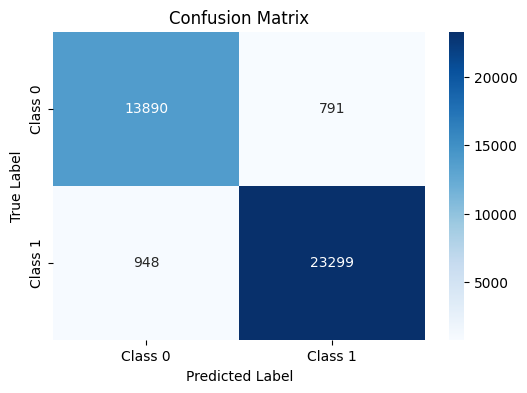

In [ ]:
## Build confusion matrix

from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
import matplotlib.pyplot as plt

# Confusion Matrix and Classification Report

# Calculate the confusion matrix
conf_matrix = confusion_matrix(all_test_labels, all_test_preds)

# Print the confusion matrix
print("Confusion Matrix:")
print(conf_matrix)

# Optionally, you can plot the confusion matrix for better visualization
plt.figure(figsize=(6, 4))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['Class 0', 'Class 1'], yticklabels=['Class 0', 'Class 1'])
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()

In [ ]:
# Print a classification report for precision, recall, and F1-score
print("Classification Report:")
print(classification_report(all_test_labels, all_test_preds, target_names=['Class 0', 'Class 1']))

Classification Report:
              precision    recall  f1-score   support

     Class 0       0.94      0.95      0.94     14681
     Class 1       0.97      0.96      0.96     24247

    accuracy                           0.96     38928
   macro avg       0.95      0.95      0.95     38928
weighted avg       0.96      0.96      0.96     38928



#### Plot the training & validation loss

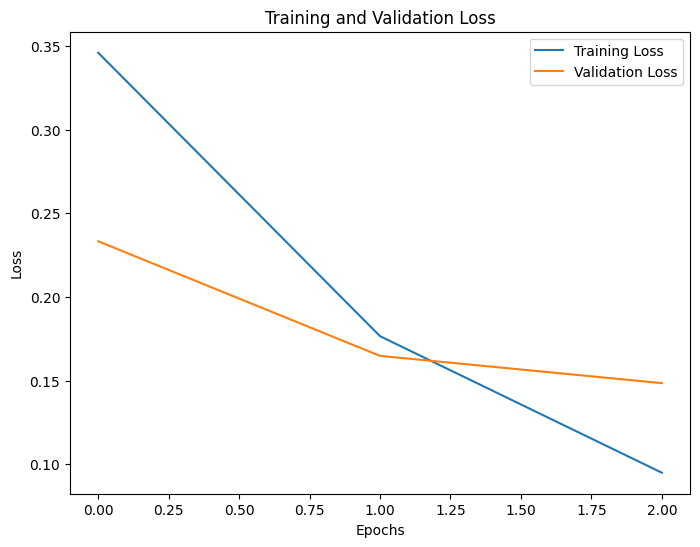

In [ ]:
import matplotlib.pyplot as plt

# Plot training and validation loss
plt.figure(figsize=(8, 6))
plt.plot(train_losses, label='Training Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()